In [8]:
import wandb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style('dark')

In [9]:
api = wandb.Api(timeout=40)
runs = api.runs("structurelearning/BIOLS")
max_steps = 20000

In [35]:
def get_reqd_runs(exp_config, runs, num_seeds=5):
    reqd_runs = []

    for run in runs:
        reqd_run = True
        for k,v in exp_config.items():
            if k not in run.config.keys() or run.config[k] != v: 
                reqd_run = False
                break
        if reqd_run is False: continue
        else: reqd_runs.append(run)   # This is a required run

    assert len(reqd_runs) == num_seeds
    return reqd_runs

def get_plotting_data(reqd_runs, reqd_keys):
    seed_data = {}
    for key in reqd_keys: seed_data[key] = []

    for run in reqd_runs:
        plotting_data = run.scan_history(reqd_keys, max_steps)

        for key in reqd_keys:
            seed_data[key].append([data[key] for data in plotting_data])
    
    for key in reqd_keys:
        seed_data[key] = np.array([x for x in seed_data[key] if x])

    return seed_data

In [46]:
exp_names = [
    'GraphVAE (vector)',
    'VAE baseline',
    'ILCM-weakly_supervised (GT Interv)',
    'ILCM-weakly_supervised (Infer Interv)',
    'BIOLS_learnL',
]

label_dict = {
    'GraphVAE (vector)': 'GraphVAE',
    'VAE baseline': 'VAE',
    'ILCM-weakly_supervised (GT Interv)': 'ILCM-GT',
    'ILCM-weakly_supervised (Infer Interv)': 'ILCM',
    'BIOLS_learnL': 'BIOLS',
    'BIOLS_Image_learnL': 'BIOLS',
}

metrics = {
    'SHD': ['SHD', 'SHD', 'SHD (Perm)', 'SHD (Perm)', 'SHD'],
    'AUROC': ['AUROC', 'AUROC', 'AUROC (Perm)', 'AUROC (Perm)', 'AUROC']
}

metrics_per_exp_name = {
    'GraphVAE (vector)': ['SHD', 'AUROC'],
    'VAE baseline': ['SHD', 'AUROC'],
    'ILCM-weakly_supervised (GT Interv)': ['SHD (Perm)', 'AUROC (Perm)'],
    'ILCM-weakly_supervised (Infer Interv)': ['SHD (Perm)', 'AUROC (Perm)'],
    'BIOLS_learnL': ['SHD', 'AUROC'],
    'BIOLS_Image_learnL': ['SHD', 'AUROC'],
}

In [47]:
def get_plot_dataframe(exp_config, runs, exp_names, reqd_keys=['SHD', 'AUROC']):
    plot_data_dict = {
        'Graph density': [],
        'Model': [],
        'biols_data_folder': []
    }
    
    for key in reqd_keys:   plot_data_dict[key] = []

    for exp_name in exp_names:
        exp_config['exp_name'] = exp_name
        exp_run = get_reqd_runs(exp_config, runs, num_seeds=5)
        reqd_keys = ['Evaluations/' + key for key in metrics_per_exp_name[exp_name]]
        plotting_data = get_plotting_data(exp_run, reqd_keys)

        splits = exp_config['biols_data_folder'].split('-')
        exp_edges = int(splits[0][-1])
        proj = splits[2][:-4]
        if proj == '3_layer_mlp':
            proj = 'nonlinear'
        d = int(splits[3][1:])
        D = int(splits[4][1:])

        for key in reqd_keys:
            num_seeds = len(plotting_data[key][:, -1])
            if 'SHD' in key:
                lhs_key = 'SHD'
            elif 'AUROC' in key:
                lhs_key = 'AUROC'
            plot_data_dict[lhs_key] += (plotting_data[key][:, -1]).tolist()

        rstring = r"$ER-{}, d={}, D={}\ $".format(exp_edges, d, D)
        plot_data_dict['Graph density'] += [rstring] * num_seeds

        label = label_dict[exp_name]
        plot_data_dict['Model'] += [label] * num_seeds
        plot_data_dict['biols_data_folder'] += [exp_config['biols_data_folder']] * num_seeds

    plot_df = pd.DataFrame(plot_data_dict)
    name = f'er{exp_edges}_d{d}_D{D}_proj{proj}'
    return plot_df, name

In [53]:
from matplotlib.patches import PathPatch


def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:
        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])


def get_legend_plot(ax, handles, basepath, filename, ncol):
    figlegend = plt.figure(figsize=(2*ncol, 2))
    plt.legend(*handles, loc ='upper left', fontsize=32, ncol=ncol)
    plt.axis("off")
    plt.savefig(f"{basepath}/{filename}.pdf",bbox_inches='tight')
    plt.close('all')


def plot_it(label_dict, plot_df, basepath, name, fontsize, title=None, box_widths=0.8):
    num_rows = 1
    num_cols = 2
    colors = ['#ea4335', '#f4b400', '#9467bd']

    models = list(label_dict.values())

    # Create the subplots
    plt.rcParams.update({'font.size': fontsize})
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 4))
    lines_labels = []

    # Iterate over the metrics
    for i, metric in enumerate(['SHD', 'AUROC']):
        # Extract the metric values for each model and seed
        data = []
        for model in models:
            model_data = plot_df[plot_df['Model'] == model][metric]
            data.append(model_data)

        # Plot the data in the subplot
        ax = axs[i]
        PROPS = {
            'boxprops':{'alpha':0.5},
            'medianprops':{'alpha':0.7},
            'whiskerprops':{'alpha':0.7},
            'capprops':{'alpha':0.7}
        }
        sns.boxplot(ax=ax, x='Graph density', y=metric, data=plot_df, hue='Model', showfliers = False, palette=colors, dodge=0.4, **PROPS)
        sns.stripplot(
            ax=ax, 
            x="Graph density", 
            y=metric, 
            data=plot_df, 
            hue='Model', 
            dodge=True, 
            alpha=.7, 
            palette=colors, 
            ec='k',
            jitter=True,
            legend=False
        )
        
        box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
        if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
            box_patches = ax.artists
        num_patches = len(box_patches)
        lines_per_boxplot = len(ax.lines) // num_patches

        for k, patch in enumerate(box_patches):
            col = patch.get_facecolor()
            patch.set_edgecolor(col)

            for line in ax.lines[k * lines_per_boxplot: (k + 1) * lines_per_boxplot]:
                line.set_color(col)
                line.set_mfc(col)  # facecolor of fliers
                line.set_mec(col)  # edgecolor of fliers

        ax.set_ylabel('')
        ax.title.set_text(metric)
        ax.grid(axis='y')

        if i == 0:
            lines_labels.append(ax.get_legend_handles_labels())
        
        ax.get_legend().remove()
        ax.set_xlabel('')
    
    adjust_box_widths(fig, box_widths)
    if title is not None:
        plt.suptitle(title)

    plt.tight_layout()
    plt.savefig(f'{basepath}/{name}_graph_eval.pdf')
    print(f'Saved to {basepath}/{name}_graph_eval.pdf')
    plt.show()

    get_legend_plot(ax, lines_labels[0], basepath, 'graph_eval_legend', ncol=len(colors))

In [54]:
def fetch_and_plot(exp_names, data_folder, basepath, box_widths=0.8, fontsize=18):
    splitted_data_folder = data_folder.split('-')
    degree = int(splitted_data_folder[0][-1])
    proj = splitted_data_folder[2][:-4]

    num_nodes = int(splitted_data_folder[3][1:])
    proj_dims = int(splitted_data_folder[4][1:])
    interv_type = splitted_data_folder[5]
    n_pairs = int(splitted_data_folder[6][7:])
    sets = int(splitted_data_folder[-2][4:])
    interv_value = splitted_data_folder[-1][:-6]

    exp_config = {
        'biols_data_folder': data_folder
    }
    plot_df, name = get_plot_dataframe(exp_config, runs, exp_names, reqd_keys=['SHD', 'AUROC'])
    plot_it(label_dict, plot_df, f'{basepath}/{data_folder}', name, fontsize, box_widths=box_widths, title=None)

5 {'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv', 'exp_name': 'GraphVAE (vector)'} 5
5 {'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv', 'exp_name': 'VAE baseline'} 5
5 {'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv', 'exp_name': 'BIOLS_Image_learnL'} 5
Saved to /home/mila/j/jithendaraa.subramanian/scratch/biols_datasets/er1-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv/er1_d5_D2500_projchemdata_graph_eval.pdf


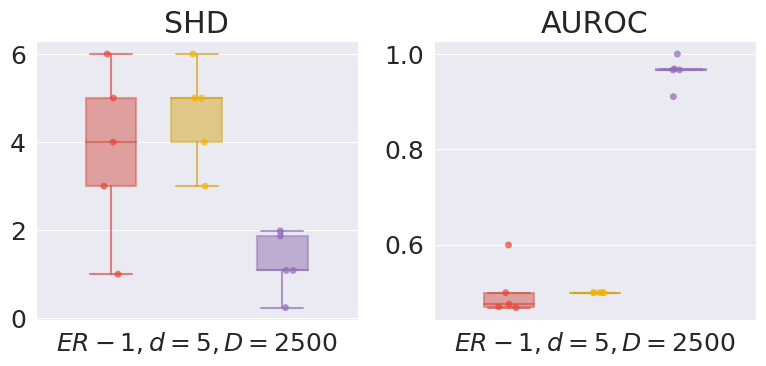

In [55]:
# chemdata d5
exp_names = [
    'GraphVAE (vector)',
    'VAE baseline',
    'BIOLS_Image_learnL',
]

fetch_and_plot(exp_names, 'er1-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv', '/home/mila/j/jithendaraa.subramanian/scratch/biols_datasets', box_widths=0.6)

5 {'biols_data_folder': 'er2-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv', 'exp_name': 'GraphVAE (vector)'} 5
5 {'biols_data_folder': 'er2-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv', 'exp_name': 'VAE baseline'} 5
5 {'biols_data_folder': 'er2-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv', 'exp_name': 'BIOLS_Image_learnL'} 5
Saved to /home/mila/j/jithendaraa.subramanian/scratch/biols_datasets/er2-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv/er2_d5_D2500_projchemdata_graph_eval.pdf


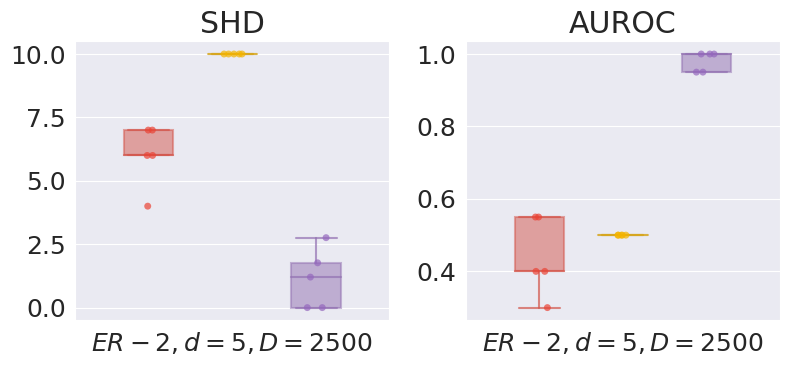

In [56]:
fetch_and_plot(exp_names, 'er2-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv', '/home/mila/j/jithendaraa.subramanian/scratch/biols_datasets', box_widths=0.6)

Saved to /home/mila/j/jithendaraa.subramanian/scratch/biols_datasets/er1-ws_datagen_fix_noise_interv_noise-linearproj-d005-D0100-multi-n_pairs2000-sets20-gaussianinterv/er1_d5_D100_projlinear_graph_eval.pdf


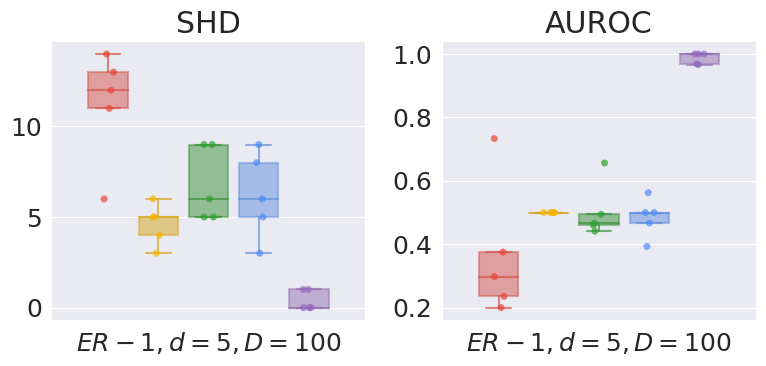

Saved to /home/mila/j/jithendaraa.subramanian/scratch/biols_datasets/er2-ws_datagen_fix_noise_interv_noise-linearproj-d005-D0100-multi-n_pairs2000-sets20-gaussianinterv/er2_d5_D100_projlinear_graph_eval.pdf


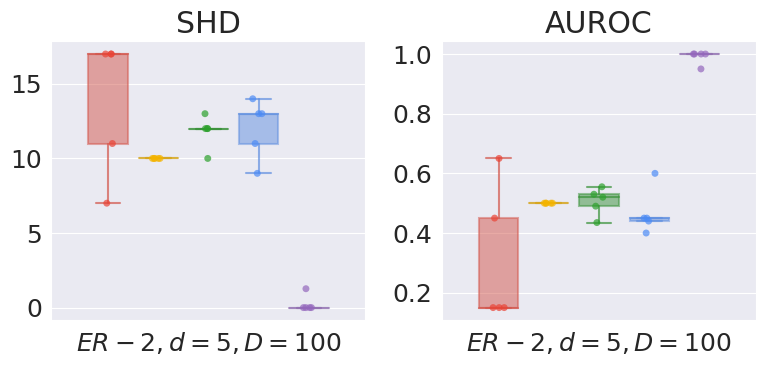

In [54]:
# linear d5
fetch_and_plot(exp_names, 'er1-ws_datagen_fix_noise_interv_noise-linearproj-d005-D0100-multi-n_pairs2000-sets20-gaussianinterv', '/home/mila/j/jithendaraa.subramanian/scratch/biols_datasets')
fetch_and_plot(exp_names, 'er2-ws_datagen_fix_noise_interv_noise-linearproj-d005-D0100-multi-n_pairs2000-sets20-gaussianinterv', '/home/mila/j/jithendaraa.subramanian/scratch/biols_datasets')

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=40 sec). Create a new API with an integer timeout larger than 40, e.g., `api = wandb.Api(timeout=50)` to increase the graphql timeout.


Saved to /home/mila/j/jithendaraa.subramanian/scratch/biols_datasets/er1-ws_datagen_fix_noise_interv_noise-3_layer_mlpproj-d005-D0100-multi-n_pairs2000-sets20-gaussianinterv/er1_d5_D100_projnonlinear_graph_eval.pdf


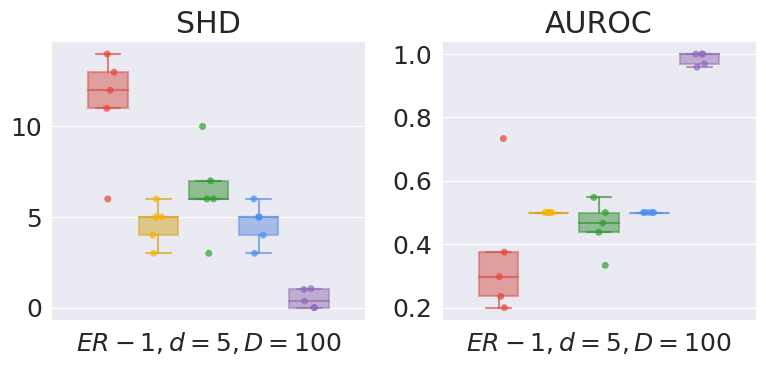

Saved to /home/mila/j/jithendaraa.subramanian/scratch/biols_datasets/er2-ws_datagen_fix_noise_interv_noise-3_layer_mlpproj-d005-D0100-multi-n_pairs2000-sets20-gaussianinterv/er2_d5_D100_projnonlinear_graph_eval.pdf


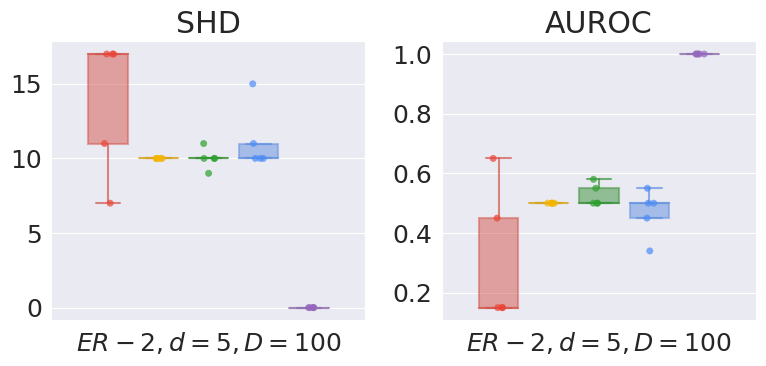

In [55]:
# nonlinear d5
fetch_and_plot(exp_names, 'er1-ws_datagen_fix_noise_interv_noise-3_layer_mlpproj-d005-D0100-multi-n_pairs2000-sets20-gaussianinterv', '/home/mila/j/jithendaraa.subramanian/scratch/biols_datasets')
fetch_and_plot(exp_names, 'er2-ws_datagen_fix_noise_interv_noise-3_layer_mlpproj-d005-D0100-multi-n_pairs2000-sets20-gaussianinterv', '/home/mila/j/jithendaraa.subramanian/scratch/biols_datasets')

Saved to /home/mila/j/jithendaraa.subramanian/scratch/biols_datasets/er1-ws_datagen_fix_noise_interv_noise-SONproj-d005-D0005-multi-n_pairs2000-sets20-gaussianinterv/er1_d5_D5_projSON_graph_eval.pdf


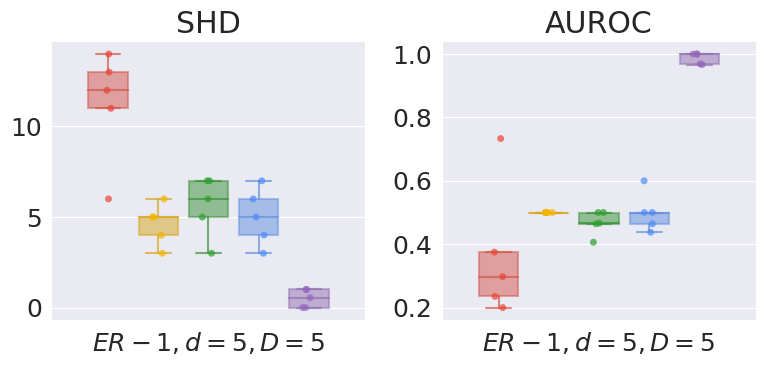

Saved to /home/mila/j/jithendaraa.subramanian/scratch/biols_datasets/er2-ws_datagen_fix_noise_interv_noise-SONproj-d005-D0005-multi-n_pairs2000-sets20-gaussianinterv/er2_d5_D5_projSON_graph_eval.pdf


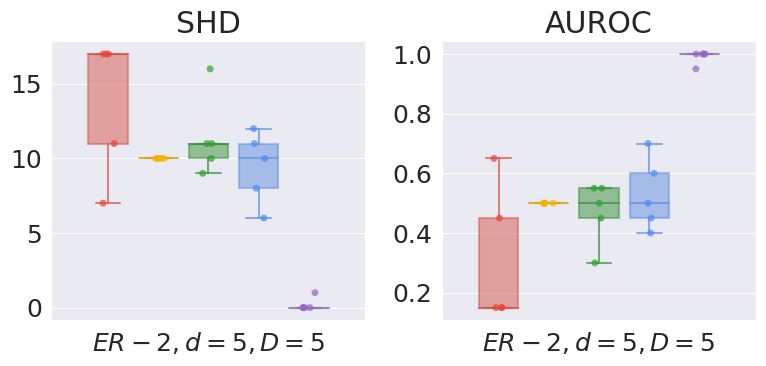

In [56]:
# SON d5
fetch_and_plot(exp_names, 'er1-ws_datagen_fix_noise_interv_noise-SONproj-d005-D0005-multi-n_pairs2000-sets20-gaussianinterv', '/home/mila/j/jithendaraa.subramanian/scratch/biols_datasets')
fetch_and_plot(exp_names, 'er2-ws_datagen_fix_noise_interv_noise-SONproj-d005-D0005-multi-n_pairs2000-sets20-gaussianinterv', '/home/mila/j/jithendaraa.subramanian/scratch/biols_datasets')

5 {'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv', 'exp_name': 'GraphVAE (vector)'} 5
5 {'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv', 'exp_name': 'VAE baseline'} 5
5 {'biols_data_folder': 'er1-ws_datagen_fix_noise_interv_noise-chemdataproj-d005-D2500-multi-n_pairs2000-sets20-gaussianinterv', 'exp_name': 'BIOLS_Image_learnL'} 5


KeyError: 'BIOLS_Image_learnL'